##### Tensorflow 作者版权 2018

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 定制化训练：基础

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/eager/custom_training"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />浏览TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/eager/custom_training.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />在Google Colab运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/eager/custom_training.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub浏览源码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/tutorials/eager/custom_training.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />下载notebook</a>
  </td>
</table>

在之前的教程中，我们讨论了自动差分，一个基本的机器学习模块。在这个教程中，我们将使用在之前介绍的Tensorflow基础语句实现简单的机器学习模型。

Tensorflow也提供了高级神经网络API(`tf.keras`)，可以精简范例代码。我们强烈建议在神经网络方面的工作使用高级的API。在这篇教程中，我们使用基本规则用于神经网络的训练，为以后打下坚实的基础。

## 创建

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf

## 变量

Tensorflow中的tensor是不可变无状态对象。机器学习模型需要可改变状态，比如模型训练和模型预测的代码是相同的，但变量值随着时间而不同(希望尽量小的loss)。为了应对随着计算而改变的状态，可以利用Python的状态可变性。


In [3]:
# 使用python状态
x = tf.zeros([10, 10])
x += 2  # 等价于 x = x + 2, 不改变原本x的值
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow，拥有内建可变状态操作，比使用底层Python状态表示更常见的。比如，表示模型的权重，使用TensorFlow变量更方便高效。

变量是一个对象，这个对象存储着数值，当在TensorFlow计算中使用时，会隐式地读取这个存储的数值。有一些操作(`tf.assign_sub`, `tf.scatter_update`, 等)会复制TensorFlow变量存储的数值。

In [4]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

# 重新赋值
v.assign(3.0)
assert v.numpy() == 3.0

# 在TensorFlow操作中使用`v`，比如tf.square()和重新赋值
v.assign(tf.square(v))
assert v.numpy() == 9.0

当计算梯度时，会自动跟踪使用变量的计算。用变量来表示向量，TensorFlow会默认使用稀疏更新，这样可以带来计算和存储高效性。

使用变量也是一种更快的提醒方式，就是代码的这部分是状态可变的。

## 示例：尝试一个线性模型

让我们来使用目前为止学到的概念---`Tensor`, `Variable`, and `GradientTape`---来创建和训练一个简单的模型。一般需要下面这些步骤：

1. 定义模型
2. 定义损失函数
3. 获取训练数据
4. 通过训练数据运行模型，使用"optimizer"来调整变量以满足数据

在这个教程中，我们使用一个简单线性模型作为示例：`f(x) = x * W + b`，有2个变量- `W` and `b`。另外，我们会生成数据让训练好的模型中`W = 3.0` 和 `b = 2.0`。

### 定义模型

定义一个简单的类封装变量和计算

In [5]:
class Model(object):
  def __init__(self):
    # 初始化变量值为(5.0, 0.0)
    # 实际上，这些变量应该初始化为随机值
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

### 定义损失函数

损失函数用来衡量在给定输入的情况下，模型的预测输出与实际的输出的偏差。我们这里使用标准L2损失函数。

In [6]:
def loss(predicted_y, desired_y):
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

### 获取训练数据

我们来生成带噪声的训练数据。

In [7]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

在训练模型之前，我们来看看当前的模型表现。我们绘制模型的预测结果和训练数据，预测结果用红色表示，训练数据用蓝色表示。

In [8]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

<Figure size 640x480 with 1 Axes>

Current loss: 
8.4688225


### 定义训练循环

我们现在有了网络模型和训练数据。现在来训练模型，即，基于[梯度下降](https://en.wikipedia.org/wiki/Gradient_descent)使用训练数据来更新模型的变量(`W` 和 `b`)使得损失量变小。梯度下降方案中有很多参数，通过`tf.train.Optimizer`实现。我们强烈建议使用这些实现方式，但基于通过基本规则创建模型的精神，在这个特别示例中，我们自己实现基本的数学运算。

In [9]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

最后，我们对训练数据重复地运行，观察`W` 和 `b`是怎么变化的。

Epoch  0: W=5.00 b=0.00, loss=8.46882
Epoch  1: W=4.63 b=0.38, loss=5.90502
Epoch  2: W=4.33 b=0.69, loss=4.21623
Epoch  3: W=4.08 b=0.94, loss=3.10372
Epoch  4: W=3.88 b=1.15, loss=2.37080
Epoch  5: W=3.72 b=1.31, loss=1.88791
Epoch  6: W=3.59 b=1.44, loss=1.56974
Epoch  7: W=3.48 b=1.55, loss=1.36008
Epoch  8: W=3.39 b=1.63, loss=1.22192
Epoch  9: W=3.32 b=1.70, loss=1.13087


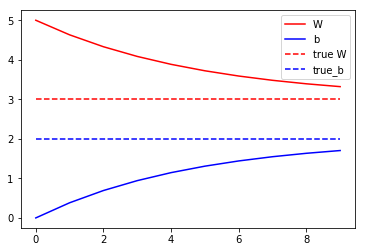

In [10]:
model = Model()

# 收集W和b的历史数值，用于显示
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# 显示所有
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()


## 下一步

在这个教程中，我们讨论了`Variable`，而且创建和训练了一个简单的线性模型，使用了在此之前所学习的TensorFlow知识点。

理论而言，用在机器学习研究上，跟TensorFlow相关的内容差不多就这些。实际上，特别是神经网络，高级的API比如`tf.keras`是更方便的，因为它提供了更高级别的内建模块(命名为"layers")，可以保存和恢复状态，成套的损失函数和优化策略等。
